In [82]:
%matplotlib inline

import os
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_similarity_score as jcs
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_curve, auc
from collections import Counter

In [2]:
data = pd.read_csv('csv_export/funding_rounds.csv')
print (data.head(n=5))
print (len(data))

                company_name country_code state_code   region     city  \
0          Undercover Colors          USA         NC  Raleigh  Raleigh   
1                Agency Core          GBR        NaN   London   London   
2                     Algama          FRA        NaN    Paris    Paris   
3                     Bayzat          ARE        NaN    Dubai    Dubai   
4  Blackmoon Financial Group          RUS        NaN   Moscow   Moscow   

                               company_category_list funding_round_type  \
0                Fashion|Lifestyle|Social Innovation            venture   
1    Business Intelligence|Cloud Computing|Real Time            venture   
2  Biotechnology|Food and Beverage|Food Processin...            venture   
3  Banking|Employee Benefits|Insurance|Price Comp...            venture   
4                                            FinTech            venture   

  funding_round_code announced_on  raised_amount_usd  \
0                NaN   2016-11-11     5500000.00

In [3]:
data = data.drop('created_at', 1)
data = data.drop('updated_at', 1)
data = data.drop('cb_url', 1)
data = data.drop('post_money_currency_code', 1)
data = data.drop('post_money_valuation_usd', 1)
data = data.drop('post_money_valuation', 1)
data = data.drop('funding_round_type', 1)
data = data.drop('country_code', 1)
data = data.drop('state_code', 1)
data = data.drop('city', 1)
data = data.drop('funding_round_code', 1)
data = data.drop('announced_on', 1)
data = data.drop('raised_amount', 1)
data = data.drop('raised_amount_currency_code', 1)
data = data.drop('target_money_raised_usd', 1)
data = data.drop('target_money_raised', 1)
data = data.drop('target_money_raised_currency_code', 1)

print (data.head(n=5))

                company_name   region  \
0          Undercover Colors  Raleigh   
1                Agency Core   London   
2                     Algama    Paris   
3                     Bayzat    Dubai   
4  Blackmoon Financial Group   Moscow   

                               company_category_list  raised_amount_usd  \
0                Fashion|Lifestyle|Social Innovation     5500000.000000   
1    Business Intelligence|Cloud Computing|Real Time                NaN   
2  Biotechnology|Food and Beverage|Food Processin...     3842564.637427   
3  Banking|Employee Benefits|Insurance|Price Comp...     3500000.000000   
4                                            FinTech     2500000.000000   

   investor_count                            investor_names  \
0               0                                       NaN   
1               2      Scottish Investment Bank, Par Equity   
2               1                  Lead - Horizons Ventures   
3               1                       Lead - BEC

In [4]:
data = data[pd.notnull(data['raised_amount_usd'])]
data = data[pd.notnull(data['investor_names'])]
data = data[data['region'].str.contains("SF")==True]
datafinal = data[pd.notnull(data['company_category_list'])]
print (datafinal.head(n=5))
print (len(datafinal))

       company_name       region  \
5    Cape Analytics  SF Bay Area   
10            Glint  SF Bay Area   
17  Intuity Medical  SF Bay Area   
24   Neo Technology  SF Bay Area   
31           RiskIQ  SF Bay Area   

                                company_category_list  raised_amount_usd  \
5                              Information Technology           14000000   
10     Enterprise Software|Human Resources|Recruiting           10000000   
17                       Diabetes|Health Care|Medical           40000000   
24    Analytics|Big Data|Database|Enterprise Software           36000000   
31  Cyber Security|Internet|Mobile|Reputation|Secu...           30500000   

    investor_count                                     investor_names  \
5                7  Lead - Formation 8, Promus Ventures, Montage V...   
10               3  Lead - Bessemer Venture Partners, Shasta Ventu...   
17               7  Lead - PTV Healthcare Capital, Investor Growth...   
24               4  Greenbridge Pa

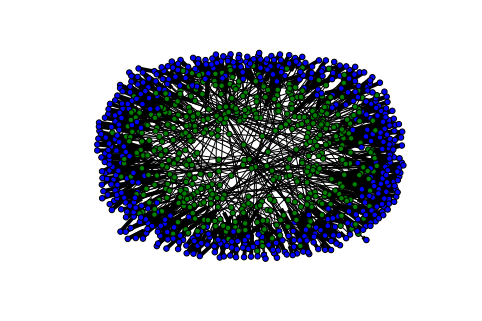

In [67]:
# Draw a subgraph just to see what it looks like
sub_g = nx.DiGraph()
for index in range(0, 500):
    node_to = str(datafinal.iloc[index]['company_name'])
    # there is only one investor
    if (datafinal.iloc[index]['investor_count'] == 1):
        node_from = str(datafinal.iloc[index]['investor_names'])
        if (node_from.find('Lead - ') != -1):
            node_from = node_from[node_from.find('Lead - ')+7:]
        edge_weight = datafinal.iloc[index]['raised_amount_usd']
        sub_g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
    
    # there are multiple investors
    else:
        inv_count = datafinal.iloc[index]['investor_count']
        # with one lead investor
        if (datafinal.iloc[index]['investor_names'].find('Lead - ') != -1):
            node_from = str(datafinal.iloc[index]['investor_names'])
            lead_inv = node_from[node_from.find('Lead - ')+7:node_from.find(',')]
            edge_weight_lead = (datafinal.iloc[index]['raised_amount_usd'])/3
            sub_g.add_weighted_edges_from([(lead_inv, node_to, edge_weight_lead)])
            invs = node_from[node_from.find(', ')+2:]
            edge_weight = (datafinal.iloc[index]['raised_amount_usd'])*2/3/(inv_count-1)
            for inv in range(0, inv_count-2):
                node_from = invs[:invs.find(',')]
                g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
                invs = invs[invs.find(', ')+2:]
            #don't forget last one
            sub_g.add_weighted_edges_from([(invs, node_to, edge_weight)])
        # with no lead investor
        else:
            invs = str(datafinal.iloc[index]['investor_names'])
            edge_weight = (datafinal.iloc[index]['raised_amount_usd'])/(inv_count)
            for inv in range(0, inv_count-1):
                node_from = invs[:invs.find(',')]
                g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
                invs = invs[invs.find(', ')+2:]
            sub_g.add_weighted_edges_from([(invs, node_to, edge_weight)])
    # attributes for company
    sub_g.node[node_to]['region'] = datafinal.iloc[index]['region']
    cat = str(datafinal.iloc[index]['company_category_list'])
    if (cat.find('|') != -1):
        cat = cat[:cat.find('|')]
    sub_g.node[node_to]['cat'] = cat
    sub_g.node[node_to]['uuid'] = datafinal.iloc[index]['company_uuid']

node_color = []
for node in sub_g.nodes_iter():
    if sub_g.out_degree(node) == 0:
        node_color.append('blue')
    else:
        node_color.append('green')

nx.draw(sub_g,arrows=True,node_size=30,pos=nx.spring_layout(sub_g,k=0.7,iterations=20),node_color=node_color)
plt.savefig('unsupervised_ex.png')

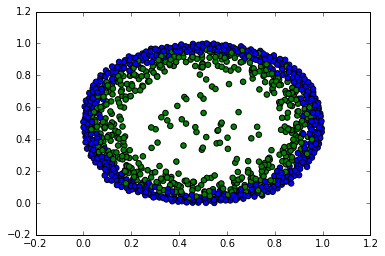

In [68]:
nx.draw_networkx_nodes(sub_g,node_size=30,pos=nx.spring_layout(sub_g), node_color=node_color)
plt.savefig('unsupervised_ex_nodes.png')

In [85]:
g = nx.DiGraph()

for index in range(0, len(datafinal)):
    node_to = str(datafinal.iloc[index]['company_name'])
    # there is only one investor
    if (datafinal.iloc[index]['investor_count'] == 1):
        node_from = str(datafinal.iloc[index]['investor_names'])
        if (node_from.find('Lead - ') != -1):
            node_from = node_from[node_from.find('Lead - ')+7:]
        edge_weight = datafinal.iloc[index]['raised_amount_usd']
        g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
    
    # there are multiple investors
    else:
        inv_count = datafinal.iloc[index]['investor_count']
        # with one lead investor
        if (datafinal.iloc[index]['investor_names'].find('Lead - ') != -1):
            node_from = str(datafinal.iloc[index]['investor_names'])
            lead_inv = node_from[node_from.find('Lead - ')+7:node_from.find(',')]
            edge_weight_lead = (datafinal.iloc[index]['raised_amount_usd'])/3
            g.add_weighted_edges_from([(lead_inv, node_to, edge_weight_lead)])
            invs = node_from[node_from.find(', ')+2:]
            edge_weight = (datafinal.iloc[index]['raised_amount_usd'])*2/3/(inv_count-1)
            for inv in range(0, inv_count-2):
                node_from = invs[:invs.find(',')]
                g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
                invs = invs[invs.find(', ')+2:]
            #don't forget last one
            g.add_weighted_edges_from([(invs, node_to, edge_weight)])
        # with no lead investor
        else:
            invs = str(datafinal.iloc[index]['investor_names'])
            edge_weight = (datafinal.iloc[index]['raised_amount_usd'])/(inv_count)
            for inv in range(0, inv_count-1):
                node_from = invs[:invs.find(',')]
                g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
                invs = invs[invs.find(', ')+2:]
            g.add_weighted_edges_from([(invs, node_to, edge_weight)])
    # attributes for company
    g.node[node_to]['region'] = datafinal.iloc[index]['region']
    cat = str(datafinal.iloc[index]['company_category_list'])
    if (cat.find('|') != -1):
        cat = cat[:cat.find('|')]
    g.node[node_to]['cat'] = cat
    g.node[node_to]['uuid'] = datafinal.iloc[index]['company_uuid']

In [86]:
# how many categories are there? --> logical starting point for clustering
out = open('cats_single.csv', 'w')
out.write('cats_single\n')
for index in range(0, len(datafinal)):
    categories = datafinal.iloc[index]['company_category_list']
    categories = categories.replace('hardware|', '')
    categories = categories.replace('hardware', '')
    categories = categories.replace('|hardware', '')
    categories = categories.replace('software|', '')
    categories = categories.replace('software', '')
    categories = categories.replace('|software', '')
    if (len(categories) == 0):
        line_out = '\n'
    else:
        cat_single = categories[:categories.find('|')]
        line_out = cat_single + '\n'
    out.write(line_out)
out.close()

In [87]:
cats_single = pd.read_csv('cats_single.csv', sep='\t')
print (cats_single.head(n=5))
print (len(cats_single))

             cats_single
0  Information Technolog
1    Enterprise Software
2               Diabetes
3              Analytics
4         Cyber Security
15183


In [88]:
unique_cats_single = cats_single.cats_single.unique()
print(len(unique_cats_single))

550


In [89]:
# k-means clustering
gr = nx.Graph(g)
a = nx.adjacency_matrix(gr)
kmeans = KMeans(n_clusters=550, random_state=0).fit(a)
labels = kmeans.labels_
print(labels)
nodes = gr.nodes(data=True)
print(nodes)
#print(kmeans.cluster_centers_)

[534 534 534 ..., 534 534 534]
[('H. Barton Co-Invest Fund', {}), ('Eos Partners', {}), ('Mariam Naficy', {}), ('WeAre.Us', {'region': 'SF Bay Area', 'cat': 'Advertising', 'uuid': '838dea94-c287-d009-6a7a-e566af327d51'}), ('SharesPost Investment Management', {}), ('Daniel Darling', {}), ('Powerhive', {'region': 'SF Bay Area', 'cat': 'Cloud Computing', 'uuid': 'bbbafbef-3282-5575-e4d4-41314f137d2d'}), ('Chattanooga Renaissance Fund', {}), ('Jin Song Gao', {}), ('Telegent Systems', {'region': 'SF Bay Area', 'cat': 'Broadcasting', 'uuid': 'e547a09f-cdd9-1d56-ebe9-e6b77ed35768'}), ('Lead - Mayfield Fund', {}), ('James Packer', {}), ('Perfect Price', {'region': 'SF Bay Area', 'cat': 'Analytics', 'uuid': '4167670f-cb38-a46c-4274-831a7fd04089'}), ('Madison Parker Capital', {}), ('Metatron Global', {}), ('Smarking', {'region': 'SF Bay Area', 'cat': 'Parking', 'uuid': '4c066f1c-7acb-30a6-5a56-93161397e043'}), ('Speakeasy', {'region': 'SF Bay Area', 'cat': 'Apps', 'uuid': 'c4ce1047-629f-deea-d9c

In [103]:
cluster_info = [[0 for x in range(2)] for y in range(len(labels))]
y = 0
for i in range(0, len(labels)):
    y = i
    cluster_info[y][0] = nodes[y]
    cluster_info[y][1] = labels[y]
print(cluster_info)

[[('H. Barton Co-Invest Fund', {}), 534], [('Eos Partners', {}), 534], [('Mariam Naficy', {}), 534], [('WeAre.Us', {'region': 'SF Bay Area', 'cat': 'Advertising', 'uuid': '838dea94-c287-d009-6a7a-e566af327d51'}), 534], [('SharesPost Investment Management', {}), 104], [('Daniel Darling', {}), 534], [('Powerhive', {'region': 'SF Bay Area', 'cat': 'Cloud Computing', 'uuid': 'bbbafbef-3282-5575-e4d4-41314f137d2d'}), 534], [('Chattanooga Renaissance Fund', {}), 534], [('Jin Song Gao', {}), 534], [('Telegent Systems', {'region': 'SF Bay Area', 'cat': 'Broadcasting', 'uuid': 'e547a09f-cdd9-1d56-ebe9-e6b77ed35768'}), 316], [('Lead - Mayfield Fund', {}), 534], [('James Packer', {}), 534], [('Perfect Price', {'region': 'SF Bay Area', 'cat': 'Analytics', 'uuid': '4167670f-cb38-a46c-4274-831a7fd04089'}), 534], [('Madison Parker Capital', {}), 534], [('Metatron Global', {}), 534], [('Smarking', {'region': 'SF Bay Area', 'cat': 'Parking', 'uuid': '4c066f1c-7acb-30a6-5a56-93161397e043'}), 534], [('Sp

In [106]:
cluster_info_df = pd.DataFrame(cluster_info)
cluster_info_df.to_csv('cluster_info_550.csv')

In [228]:
cluster_cats = pd.DataFrame()

for c in range(0, 550):
    curr_c = cluster_info[cluster_info[:,1] == c]
    curr_c_cats = []
    for i in range(0, len(curr_c)):
        if (len(curr_c[i,0][1]) != 0):
            cat = curr_c[i,0][1]['cat']
            curr_c_cats.append(cat)
    cluster_cats = cluster_cats.append({'cluster':c, 'cluster_cats':curr_c_cats, 'cluster_cats_counts':Counter(curr_c_cats), 'node_count':len(curr_c), 'comps_count':len(curr_c_cats)}, ignore_index=True)
print(cluster_cats)

     cluster                                       cluster_cats  \
0          0  [Cloud Security, Crowdsourcing, Biotechnology,...   
1          1                                      [Mobile Apps]   
2          2                                                 []   
3          3                                                 []   
4          4                                         [Internet]   
5          5                                                 []   
6          6                                      [Hospitality]   
7          7                                                 []   
8          8                             [Consumer Electronics]   
9          9                                                 []   
10        10                            [Business Intelligence]   
11        11                                       [Automotive]   
12        12                             [Cloud Infrastructure]   
13        13                                        [Analytics

In [231]:
print(cluster_cats.iloc[0]['cluster_cats_counts']['Biotechnology'])

13


In [161]:
cluster_cats.to_csv('cluster_cats_550.csv', index=None)

# Evaluation

### Completeness Score

In [162]:
#cluster_cats = pd.read_csv('cluster_cats_550.csv', sep=',')
#print(cluster_cats.head(n=5))
#print(len(cluster_cats))

   Unnamed: 0  cluster                                       cluster_cats  \
0           0        0  ['Cloud Security', 'Crowdsourcing', 'Biotechno...   
1           1        1                                    ['Mobile Apps']   
2           2        2                                                 []   
3           3        3                                                 []   
4           4        4                                       ['Internet']   

                                 cluster_cats_counts  comps_count  node_count  
0  Counter({'Biotechnology': 13, 'Health Care': 3...           38          38  
1                        Counter({'Mobile Apps': 1})            1           1  
2                                          Counter()            0           1  
3                                          Counter()            0           1  
4                           Counter({'Internet': 1})            1           1  
550


In [225]:
#newlist = cluster_cats.iloc[0]['cluster_cats_counts'].split(',')
#print(newlist)
#index = [i for i, s in enumerate(newlist) if 'Analytics' in s]
#print(index)
#print(type(index[0]))
#index = index[0]
#print(newlist[index].index(': '))
#print(newlist[index][newlist[index].index(': ')+2:])

["Counter({'Biotechnology': 13", " 'Health Care': 3", " 'Electronics': 2", " 'Information Technology': 2", " 'Analytics': 2", " 'Cloud Security': 2", " 'Crowdsourcing': 1", " 'Biopharma': 1", " 'Enterprise Software': 1", " 'Optical Communication': 1", " 'Internet': 1", " 'Compliance': 1", " 'Automotive': 1", " 'Medical Device': 1", " 'Home Automation': 1", " 'Diabetes': 1", " 'Ad Targeting': 1", " 'Financial Services': 1", " 'Apps': 1", " 'Information Services': 1})"]
[4]
<class 'int'>
12
2


In [163]:
#cats_counts = cats_single.iloc[:,0].value_counts()

In [233]:
inc_scores = pd.DataFrame()

for i in range(0, len(cats_counts)):
    cat = cats_counts.keys()[i]
    tot = cats_counts[i]
    max_count = 0
    for j in range(0, len(cluster_cats)):
        curr_counts = cluster_cats.iloc[0]['cluster_cats_counts']
        if (cat in str(curr_counts)):
            count = int(curr_counts[cat])
            if (count > max_count):
                max_count = count
    inc_scores = inc_scores.append({'category':cat, 'score':(max_count/tot)}, ignore_index=True)
print(inc_scores)

                          category     score
0                        Analytics  0.002010
1                    Biotechnology  0.017241
2                      Advertising  0.000000
3                             Apps  0.001825
4              Enterprise Software  0.001838
5                  Cloud Computing  0.000000
6                      Health Care  0.006682
7                       E-Commerce  0.000000
8                         Internet  0.002755
9                           Mobile  0.000000
10                         Softwar  0.000000
11                        Big Data  0.000000
12                        Hardware  0.000000
13                     Electronics  0.009217
14                        Computer  0.000000
15            Consumer Electronics  0.000000
16                         Android  0.000000
17                   Manufacturing  0.000000
18                         Finance  0.000000
19                      Automotive  0.007092
20                   Collaboration  0.000000
21        

In [234]:
inc_scores.to_csv('inc_scores_550.csv', index=None)

In [238]:
inc_scores.sort_values(['score'], axis=0, ascending=[False])

,category,score
345,Medical Device,0.333333
226,Optical Communication,0.142857
195,Home Automation,0.100000
185,Diabetes,0.090909
144,Compliance,0.058824
69,Cloud Security,0.045455
85,Ad Targeting,0.026316
63,Information Services,0.020833
1,Biotechnology,0.017241
21,Information Technology,0.015267


In [261]:
print(cats_counts['Apps'])

548
